In [1]:
import numpy as np
import pandas as pd
from time import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

# from pre_process import *
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def clean_format(train_df):
    train_df[['count', 'city']] = train_df.prov.str.split("_", expand = True)
    train_df['city'] = 'city_' + train_df['city']
    train_df.drop(['prov', 'count'],axis=1,inplace=True)
    return train_df

In [3]:
df_general = pd.read_csv('../datasets/domain_general/random_sample_5w.csv')
df_general = clean_format(df_general)

In [4]:
from math import sqrt
from collections import Counter

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import LabelEncoder

def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res


def exps(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.exp(res[l])).values)
        res.columns.values[m] = l + '_exp'
        m += 1
    return res


def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res


def calculate_nctt(rtt, loss_rate):
    return 8 * rtt + loss_rate * 8 * 2.5


def calculate_throughput(rtt, loss_rate):
    if (rtt-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    return 1460.0 / rtt / 1024 * (1 / sqrt(loss_rate)) # unit MB/s


def calculate_throughput_improved(rtt, loss_rate):
    if (rtt-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    return min(4194304.0/rtt/1024, 1/(rtt*sqrt(4/3*loss_rate) +
                                      min(1, 3*sqrt(0.75*loss_rate))*loss_rate*(1+32*loss_rate*loss_rate)))


def get_outliers(df, columns, weight=1.5):
    indices = []
    for col in columns:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_list = df[(df[col] < Q1 - weight * IQR) | (df[col] > Q3 + weight * IQR)].index
        indices.extend(outlier_list)
    indices = Counter(indices)
    result = []
    for i in indices:
        if indices[i] > 2:
            result.append(i)
    return result


def feature_engineering1(df, cat_trans_flag=True):
    # 1. Remove Outliers
    '''
    @Source:
    https://www.kaggle.com/code/joonasyoon/dl-practice-on-regression#Outliers
    '''
    dff = df.copy()
    out_num_lst = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'inner_network_rtt']
    outliers = get_outliers(dff, out_num_lst)
    dff.drop(index=outliers, axis=0, inplace=True)
    print('Remove {} outlier(s)'.format(len(outliers)))

    # 2. Rolling Window
    for f1 in ['icmp_lossrate', 'synack1_ratio', 'icmp_rtt', 'avg_fbt_time', 'reset_ratio']:
        for f2 in ['domain_name', 'node_name']:
            for i in range(1, 4):
                dff[f1 + '_' + f2 + '_shift_%d' % i] = dff.groupby(f2)[f1].shift(i)
            for i in range(1, 3):
                dff[f1 + '_' + f2 + '_shift_-%d' % i] = dff.groupby(f2)[f1].shift(-i)
            dff[f1 + '_' + f2 + '_mean_decay'] = dff[f1] * 0.5 + dff[f1 + '_' + f2 + '_shift_1'] * 0.3 + \
                                                dff[f1 + '_' + f2 + '_shift_2'] * 0.1 + \
                                                dff[f1 + '_' + f2 + '_shift_3'] * 0.1
        dff[f1 + '_rolling_mean_10'] = dff[f1].rolling(window=10, min_periods=1, center=True).mean()
        dff[f1 + '_rolling_mean_30'] = dff[f1].rolling(window=30, min_periods=1, center=True).mean()
    dff = dff.fillna(0)

    df_features = dff.copy()
    # df_features[['First', 'domain']] = df_features.domain_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features[['First', 'node']] = df_features.node_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features['domain'] = df_features['domain'].astype('int64')
    # df_features['node'] = df_features['node'].astype('int64')

    df_features['odd_synack1_ratio'] = 1 - df_features['synack1_ratio']
    df_features['odd_icmp_lossrate'] = 1 - df_features['icmp_lossrate']
    df_features['odd_ratio_499_5xx'] = 1 - df_features['ratio_499_5xx']
    df_features['odd_ng_traf_level'] = 1 - df_features['ng_traf_level']
    df_features['odd_inner_network_droprate'] = 1 - df_features['inner_network_droprate']

    df_features["nctt"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_nctt(*x), axis=1)
    df_features["bw_up"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput(*x), axis=1)
    df_features["bw_im"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput_improved(*x),
                                                                            axis=1)
    # 3. Skew transform
    numeric = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'synack1_ratio', 'reset_ratio',
               'tcp_conntime', 'icmp_lossrate',  'ratio_499_5xx',
               'inner_network_droprate', 'cpu_util', 'mem_util',
               'io_await_avg', 'io_await_max', 'io_util_avg', 'io_util_max','ng_traf_level']
    skew_features = df_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
    for i in skew_index:
        df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))

    df_features['total_delay'] = (df_features['avg_fbt_time'] + df_features['tcp_conntime'] + df_features['icmp_rtt'])
    df_features['total_io_delay'] = df_features['io_await_avg'] + df_features['io_await_max']
    df_features['delta_io_delay'] = df_features['io_await_max'] - df_features['io_await_avg']
    df_features['delta_io_util'] = df_features['io_util_max'] - df_features['io_util_avg']
    df_features['avg_util'] = (0.5 * df_features['cpu_util']) + (0.5 * df_features['mem_util'])

    log_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_rtt', 'icmp_lossrate', 'io_util_avg',
                    'avg_fbt_time', 'synack1_ratio', 'tcp_conntime', 'inner_network_droprate', 'cpu_util',
                    'io_util_max','total_delay', 'delta_io_util', 'avg_util', 'nctt', 'bw_up', 'bw_im']
    df_features = logs(df_features, log_features)
    # exp_features = mi_reg_lst.remove('node')
    exp_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                    'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                    'total_delay', 'delta_io_util', 'avg_util']
    df_features = exps(df_features, exp_features)
    squared_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                        'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                        'total_delay', 'delta_io_util', 'avg_util']
    df_features = squares(df_features, squared_features)

    df_features.drop(labels=['inner_network_rtt'], axis=1, inplace=True)
    df_features['id'] = df_features['node_name'] + df_features['domain_name']
    df_features['no'] = df_features.groupby(['id'])['buffer_rate'].cumcount()
    df_features['no_max'] = df_features.groupby(['id'])['no'].transform('max')
    # Categorical
    if cat_trans_flag:
        for f in ['domain_name', 'node_name', 'city', 'isp', 'id']:
            le = LabelEncoder()
            le.fit(df_features[f])
            dic = {x: le.transform([x])[0] for x in df_features[f].unique()}
            df_features[f] = df_features[f].map(dic)
    df_labels = df_features['buffer_rate'].reset_index(drop=True)
    df_features = df_features.drop(['buffer_rate'], axis=1)
    return df_features, df_labels

In [5]:
df_general_features, df_general_labels = feature_engineering1(df_general)

Remove 23 outlier(s)
There are 14 numerical features with Skew > 0.5 :


In [6]:
from xgboost import XGBRegressor
general_seed = 42
general_xg_best = XGBRegressor(learning_rate=0.01,
                           # gamma=0.6,
                           max_depth=5,
                           n_estimators=3000,
                           # subsample=random_search.best_params_["subsample"],
                           # colsample_bytree=random_search.best_params_["colsample_bytree"],
                           objective='reg:absoluteerror',
                           nthread=5,
                           seed=general_seed,
                           reg_alpha=1,
                           tree_method='gpu_hist',
                           gpu_id=1,
                           random_state=general_seed)
start1 = time()
general_xg_best.fit(df_general_features.values, df_general_labels.values)
end1 = time()

In [7]:
df_general_lst = df_general.columns.to_list()

feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = df_general_features.columns.to_list()
feature_importance['fea_imp']  = general_xg_best.feature_importances_
general_importance = feature_importance.loc[feature_importance['fea_name'].isin(df_general_lst)].copy()
general_importance.sort_values('fea_imp',ascending = False,inplace=True)
general_importance['fea_imp'] = general_importance['fea_imp'] / sum(general_importance['fea_imp'])*100
general_importance

,fea_name,fea_imp
2,domain_name,15.294516
4,node_name,11.326482
7,reset_ratio,9.756846
3,isp,9.561665
20,city,6.250784
9,icmp_lossrate,5.963556
6,synack1_ratio,5.166911
1,hour_sequence,3.605804
10,icmp_rtt,3.518812
5,avg_fbt_time,3.516587


In [8]:
len(general_importance)

21

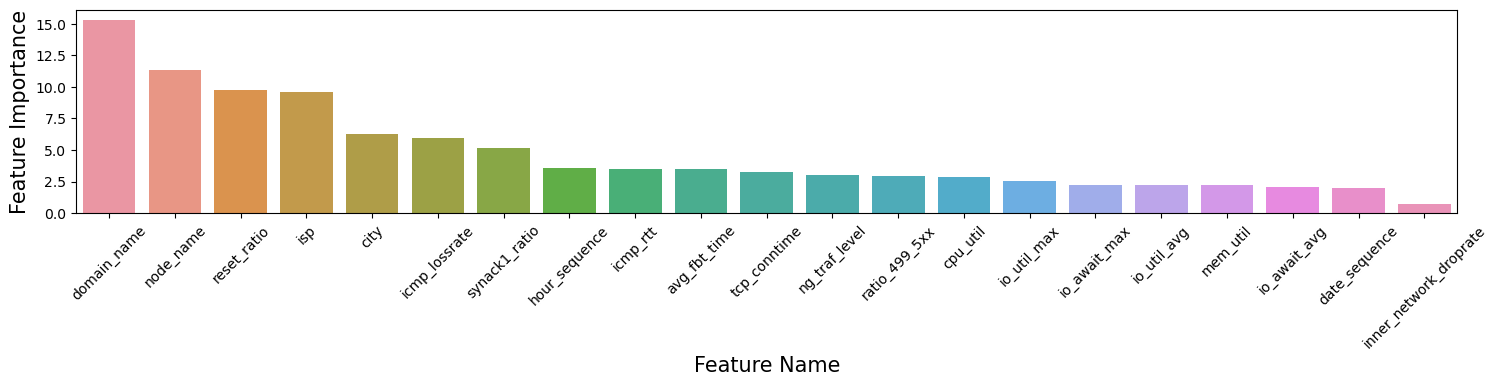

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[15,4],dpi=100)
general_labels = general_importance['fea_name'].to_list()
ax = sns.barplot(x =general_labels, y = general_importance['fea_imp'])
ax.set_xticklabels(labels = general_labels, rotation = 45, fontsize=10)
# ax.set_yticklabels(fontsize = 15)
plt.xlabel('Feature Name',fontsize=15)
plt.ylabel('Feature Importance',fontsize=15)
plt.tight_layout()

In [10]:
seed = 4

df = pd.read_csv('../datasets/domain_specific/domain_specific_isp_11domain_10prov_18.csv')
df = clean_format(df)
# s1, s2, s3 = 7952, 14309, 20397
s = len(df) // 3
train_df = df.iloc[:s, :].sample(n=8000, random_state=seed)
train_df.sort_index(ascending=True, inplace=True)
test_df1 = df.iloc[s:s*2, :].sample(n=8000, random_state=seed)
test_df1.sort_index(ascending=True, inplace=True)
test_df2 = df.iloc[s*2:s*3, :].sample(n=8000, random_state=seed)
test_df2.sort_index(ascending=True, inplace=True)

In [11]:
def feature_engineering(df, cat_trans_flag=True):
    # 1. Remove Outliers
    '''
    @Source:
    https://www.kaggle.com/code/joonasyoon/dl-practice-on-regression#Outliers
    '''
    dff = df.copy()
    # out_num_lst = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'inner_network_rtt']
    # outliers = get_outliers(dff, out_num_lst)
    # dff.drop(index=outliers, axis=0, inplace=True)
    # print('Remove {} outlier(s)'.format(len(outliers)))

    # 2. Rolling Window
    for f1 in ['icmp_lossrate', 'synack1_ratio', 'icmp_rtt', 'avg_fbt_time', 'reset_ratio']:
        for f2 in ['domain_name', 'node_name']:
            for i in range(1, 4):
                dff[f1 + '_' + f2 + '_shift_%d' % i] = dff.groupby(f2)[f1].shift(i)
            for i in range(1, 3):
                dff[f1 + '_' + f2 + '_shift_-%d' % i] = dff.groupby(f2)[f1].shift(-i)
            dff[f1 + '_' + f2 + '_mean_decay'] = dff[f1] * 0.5 + dff[f1 + '_' + f2 + '_shift_1'] * 0.3 + \
                                                dff[f1 + '_' + f2 + '_shift_2'] * 0.1 + \
                                                dff[f1 + '_' + f2 + '_shift_3'] * 0.1
        dff[f1 + '_rolling_mean_10'] = dff[f1].rolling(window=10, min_periods=1, center=True).mean()
        dff[f1 + '_rolling_mean_30'] = dff[f1].rolling(window=30, min_periods=1, center=True).mean()
    dff = dff.fillna(0)

    df_features = dff.copy()
    # df_features[['First', 'domain']] = df_features.domain_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features[['First', 'node']] = df_features.node_name.str.split("_", expand=True)
    # df_features.drop(labels=['First'], axis=1, inplace=True)
    # df_features['domain'] = df_features['domain'].astype('int64')
    # df_features['node'] = df_features['node'].astype('int64')

    df_features['odd_synack1_ratio'] = 1 - df_features['synack1_ratio']
    df_features['odd_icmp_lossrate'] = 1 - df_features['icmp_lossrate']
    df_features['odd_ratio_499_5xx'] = 1 - df_features['ratio_499_5xx']
    df_features['odd_ng_traf_level'] = 1 - df_features['ng_traf_level']
    df_features['odd_inner_network_droprate'] = 1 - df_features['inner_network_droprate']

    df_features["nctt"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_nctt(*x), axis=1)
    df_features["bw_up"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput(*x), axis=1)
    df_features["bw_im"] = df_features[["icmp_rtt", "icmp_lossrate"]].apply(lambda x: calculate_throughput_improved(*x),
                                                                            axis=1)
    # 3. Skew transform
    numeric = ['avg_fbt_time', 'tcp_conntime', 'icmp_rtt', 'synack1_ratio', 'reset_ratio',
               'tcp_conntime', 'icmp_lossrate',  'ratio_499_5xx',
               'inner_network_droprate', 'cpu_util', 'mem_util',
               'io_await_avg', 'io_await_max', 'io_util_avg', 'io_util_max','ng_traf_level']
    skew_features = df_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
    for i in skew_index:
        df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))

    df_features['total_delay'] = (df_features['avg_fbt_time'] + df_features['tcp_conntime'] + df_features['icmp_rtt'])
    df_features['total_io_delay'] = df_features['io_await_avg'] + df_features['io_await_max']
    df_features['delta_io_delay'] = df_features['io_await_max'] - df_features['io_await_avg']
    df_features['delta_io_util'] = df_features['io_util_max'] - df_features['io_util_avg']
    df_features['avg_util'] = (0.5 * df_features['cpu_util']) + (0.5 * df_features['mem_util'])

    log_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_rtt', 'icmp_lossrate', 'io_util_avg',
                    'avg_fbt_time', 'synack1_ratio', 'tcp_conntime', 'inner_network_droprate', 'cpu_util',
                    'io_util_max','total_delay', 'delta_io_util', 'avg_util', 'nctt', 'bw_up', 'bw_im']
    df_features = logs(df_features, log_features)
    # exp_features = mi_reg_lst.remove('node')
    exp_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                    'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                    'total_delay', 'delta_io_util', 'avg_util']
    df_features = exps(df_features, exp_features)
    squared_features = ['ng_traf_level', 'ratio_499_5xx', 'icmp_lossrate', 'io_util_avg',
                        'synack1_ratio', 'inner_network_droprate', 'cpu_util', 'io_util_max',
                        'total_delay', 'delta_io_util', 'avg_util']
    df_features = squares(df_features, squared_features)

    df_features.drop(labels=['inner_network_rtt'], axis=1, inplace=True)
    df_features['id'] = df_features['node_name'] + df_features['domain_name']
    df_features['no'] = df_features.groupby(['id'])['buffer_rate'].cumcount()
    df_features['no_max'] = df_features.groupby(['id'])['no'].transform('max')
    # Categorical
    if cat_trans_flag:
        for f in ['domain_name', 'node_name', 'city', 'isp', 'id']:
            le = LabelEncoder()
            le.fit(df_features[f])
            dic = {x: le.transform([x])[0] for x in df_features[f].unique()}
            df_features[f] = df_features[f].map(dic)
    df_labels = df_features['buffer_rate'].reset_index(drop=True)
    df_features = df_features.drop(['buffer_rate'], axis=1)
    return df_features, df_labels*100

In [12]:
train_df_features, train_df_labels = feature_engineering(train_df, False)
test_df1_features, test_df1_labels = feature_engineering(test_df1, False)
test_df2_features, test_df2_labels = feature_engineering(test_df2, False)

df['id'] = df['node_name'] + df['domain_name']
for f in ['domain_name', 'city', 'isp', 'node_name', 'id']:
    le = LabelEncoder()
    le.fit(df[f])
    dic1 = {x: le.transform([x])[0] for x in df[f].unique()}
    train_df_features[f] = train_df_features[f].map(dic1)
    test_df1_features[f] = test_df1_features[f].map(dic1)
    test_df2_features[f] = test_df2_features[f].map(dic1)

There are 13 numerical features with Skew > 0.5 :
There are 14 numerical features with Skew > 0.5 :
There are 13 numerical features with Skew > 0.5 :


In [13]:
xg_best = XGBRegressor(learning_rate=0.01,
                       # gamma=0.6,
                       max_depth=5,
                       n_estimators=1000,
                       # subsample=random_search.best_params_["subsample"],
                       # colsample_bytree=random_search.best_params_["colsample_bytree"],
                       objective='reg:absoluteerror',
                       nthread=5,
                       seed=seed,
                       reg_alpha=1,
                       tree_method='gpu_hist',
                       gpu_id=1,
                       random_state=seed)
start1 = time()
xg_best.fit(train_df_features.values, train_df_labels.values)
end1 = time()

In [14]:
df_lst = df.columns.to_list()

feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_df_features.columns.to_list()
feature_importance['fea_imp']  = xg_best.feature_importances_
df_feature_importance = feature_importance.loc[feature_importance['fea_name'].isin(df_lst)]
df_feature_importance['fea_imp'] = df_feature_importance['fea_imp'] / sum(df_feature_importance['fea_imp'])*100
df_feature_importance

,fea_name,fea_imp
0,date_sequence,11.606827
1,hour_sequence,8.313650
2,domain_name,0.000000
3,isp,0.000000
4,node_name,3.270838
5,avg_fbt_time,3.200595
6,synack1_ratio,4.532471
7,reset_ratio,5.393924
8,tcp_conntime,4.214339
9,icmp_lossrate,4.016402


In [15]:
len(df_feature_importance)

22

In [16]:
df_feature_importance.drop(df_feature_importance.index[-1], inplace=True)
df_feature_importance

,fea_name,fea_imp
0,date_sequence,11.606827
1,hour_sequence,8.313650
2,domain_name,0.000000
3,isp,0.000000
4,node_name,3.270838
5,avg_fbt_time,3.200595
6,synack1_ratio,4.532471
7,reset_ratio,5.393924
8,tcp_conntime,4.214339
9,icmp_lossrate,4.016402


In [17]:
len(df_feature_importance)

21

In [18]:
df_feature_importance.sort_values('fea_imp',ascending = False,inplace=True)

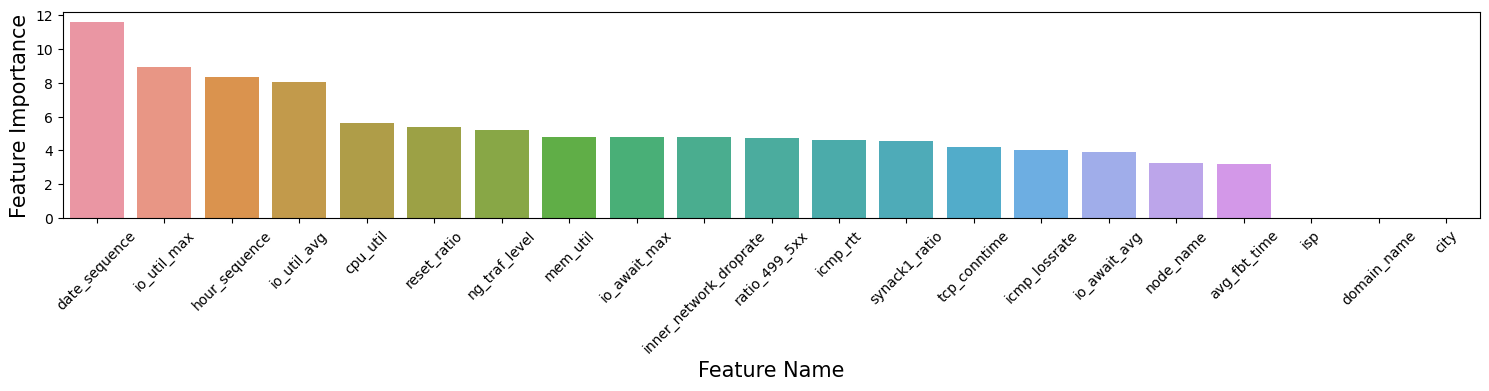

In [19]:
plt.figure(figsize=[15,4],dpi=100)
labels = df_feature_importance['fea_name'].to_list()
ax = sns.barplot(x =labels, y = df_feature_importance['fea_imp'])
ax.set_xticklabels(labels = labels, rotation = 45, fontsize=10)
# ax.set_yticklabels(fontsize = 15)
plt.xlabel('Feature Name',fontsize=15)
plt.ylabel('Feature Importance',fontsize=15)
plt.tight_layout()

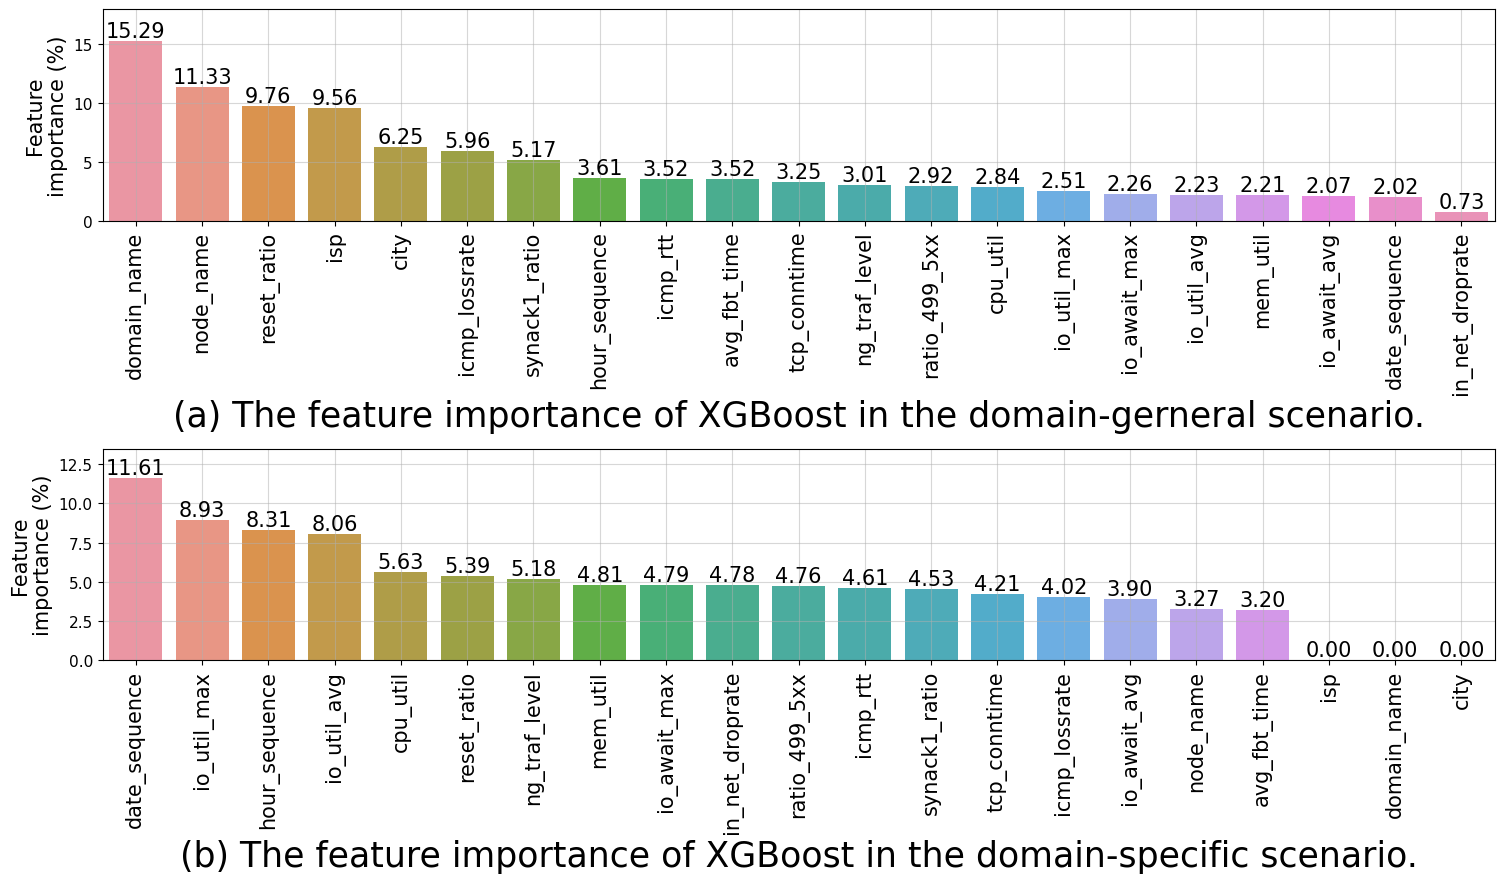

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi=100)
label_size = 15
A_as_ticklabel = [f"{a:.2f}" for a in general_importance['fea_imp'].values]
general_labels = general_importance['fea_name'].to_list()
general_labels[-1] = 'in_net_droprate'
ax1 = sns.barplot(x =general_labels, y = general_importance['fea_imp'], ax=axes[0])
ax1.grid(alpha=0.5)
# ax1.set_yticklabels(fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xticklabels(labels = general_labels, rotation = 90, fontsize=label_size)
# ax1.set_yscale('log')
ax1.bar_label(ax1.containers[0], label_type='edge', labels=A_as_ticklabel, fontsize=15)
ax1.set_xlabel('(a) The feature importance of XGBoost in the domain-gerneral scenario.' , fontsize=25)
ax1.set_ylabel('Feature\nimportance (%)', fontsize=15)
ax1.set_ylim(top=18)

A_as_ticklabe2 = [f"{a:.2f}" for a in df_feature_importance['fea_imp'].values]
sepcific_labels = df_feature_importance['fea_name'].to_list()
sepcific_labels[9] = 'in_net_droprate'
ax2 = sns.barplot(x =sepcific_labels, y = df_feature_importance['fea_imp'], ax=axes[1])
ax2.grid(alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.set_xticklabels(labels = sepcific_labels, rotation = 90, fontsize=label_size)
# ax2.set_yscale('log')
ax2.bar_label(ax2.containers[0], label_type='edge', labels=A_as_ticklabe2, fontsize=15)
ax2.set_xlabel('(b) The feature importance of XGBoost in the domain-specific scenario.' , fontsize=25)
ax2.set_ylabel('Feature\nimportance (%)', fontsize=15)
ax2.set_ylim(top=13.5)

fig.tight_layout()
# fig.savefig('./xgboost_fea_imp.pdf')